# Using observatory data as Remote Reference

This is an example notebook for processing broadband data with an QF data as a remote reference.  This assumes an MTH5 for the QF data has already been created. 

In [1]:
%matplotlib widget

## Combine Runs with sample rate of 50 Hz

Now we need to combine runs of various sample rates into a single run with the sample rate of 50 Hz.

In [2]:
from pathlib import Path

from mth5 import read_file
from mth5.io.zen import Z3DCollection
from mth5.mth5 import MTH5
from mtpy import MT

2023-04-18 15:23:31,212 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


In [8]:
station = "gz332"

In [9]:
zc = Z3DCollection(r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\{0}".format(station))
runs = zc.get_runs(sample_rates=[4096, 256])

In [10]:
runs[station]["sr256_0003"]

,survey,station,run,start,end,channel_id,component,fn,sample_rate,file_size,n_samples,sequence_number,instrument_id,coil_number,calibration_fn
4,geysers01,gz332,sr256_0003,2021-04-08 01:09:58+00:00,2021-04-08 07:21:45.683594+00:00,4,ex,c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021...,256.0,22839996,5710767,3,ZEN_046,356.5,None
5,geysers01,gz332,sr256_0003,2021-04-08 01:09:58+00:00,2021-04-08 07:21:45.683594+00:00,5,ey,c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021...,256.0,22839996,5710767,3,ZEN_046,332,None
6,geysers01,gz332,sr256_0003,2021-04-08 01:09:58+00:00,2021-04-08 07:21:45.687500+00:00,1,hx,c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021...,256.0,22843072,5710768,3,ZEN_046,2284,None
7,geysers01,gz332,sr256_0003,2021-04-08 01:09:58+00:00,2021-04-08 07:21:45.683594+00:00,2,hy,c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021...,256.0,22843068,5710767,3,ZEN_046,2294,None


In [11]:
m = MTH5()
m.open_mth5(zc.file_path.joinpath(f"{station}_with_50hz_02.h5"))

2023-04-18 15:25:07,837 [line 672] mth5.mth5.MTH5._initialize_file - INFO: Initialized MTH5 0.2.0 file c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz332\gz332_with_50hz_02.h5 in mode a


In [12]:
%%time
survey_group = m.add_survey("geysers01")
for station_id in runs.keys():
    station_group = survey_group.stations_group.add_station(station_id)
    station_group.metadata.update(zc.station_metadata_dict[station_id])
    station_group.write_metadata()
    run_list = []
    for run_id, run_df in runs[station_id].items():
        run_group = station_group.add_run(run_id)
        for row in run_df.itertuples():
            ch_ts = read_file(
                row.fn,
                calibration_fn=r"c:\Users\jpeacock\OneDrive - DOI\MTData\amtant.cal",
            )
            run_group.from_channel_ts(ch_ts)
        run_group.update_run_metadata()
        run_list.append(run_group.to_runts())

    combined_run = run_list[0].merge(run_list[1:], new_sample_rate=50)
    combined_run.run_metadata.id = "sr50_0001"
    combined_run_group = station_group.add_run("sr50_0001")
    combined_run_group.from_runts(combined_run)
    combined_run_group.update_run_metadata()

    station_group.update_station_metadata()

survey_group.update_survey_metadata()

2023-04-18 15:25:15,744 [line 358] mth5.timeseries.run_ts.RunTS._align_channels - INFO: Channels do not have a common end, using latest: 2021-04-08T01:09:43.999023437
2023-04-18 15:25:17,531 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-08T01:09:43.998779296+00:00 does not match metadata end 2021-04-08T01:09:43.999023437+00:00 updating metatdata value to 2021-04-08T01:09:43.998779296+00:00
2023-04-18 15:25:23,166 [line 358] mth5.timeseries.run_ts.RunTS._align_channels - INFO: Channels do not have a common end, using latest: 2021-04-08T06:59:43.996094000
2023-04-18 15:25:29,101 [line 358] mth5.timeseries.run_ts.RunTS._align_channels - INFO: Channels do not have a common end, using latest: 2021-04-08T07:09:43.999023437
2023-04-18 15:25:30,809 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-08T07:09:43.998779296+00:00 does not match metadata end 2021-04-08T07:09:43.999023437+00:00 updating 

Wall time: 54.2 s


In [13]:
m.close_mth5()

2023-04-18 15:26:15,554 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz332\gz332_with_50hz_02.h5


In [14]:
combined_run

RunTS Summary:
	Survey:      geysers01
	Station:     gz332
	Run:         sr50_0001
	Start:       2021-04-07T22:14:59+00:00
	End:         2021-04-08T16:24:41.988000+00:00
	Sample Rate: 50.0
	Components:  ['ex', 'ey', 'hx', 'hy']

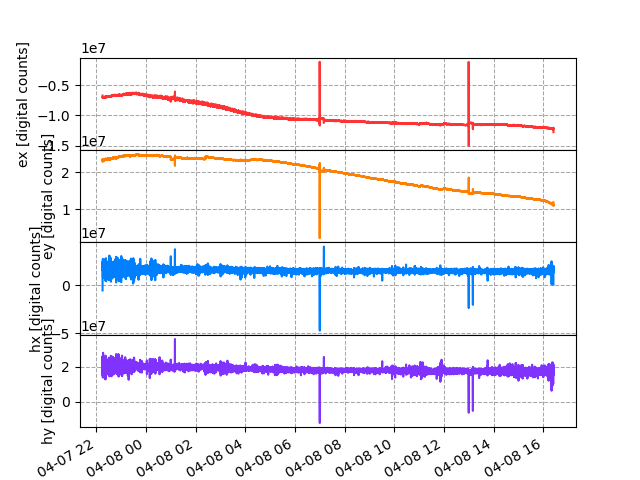

In [10]:
combined_run.plot()

In [11]:
c = combined_run.calibrate()

2023-04-18 14:51:12,087 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-08T16:24:41.980000+00:00 does not match metadata end 2021-04-08T16:24:41.988000+00:00 updating metatdata value to 2021-04-08T16:24:41.980000+00:00
2023-04-18 14:51:13,699 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 14:51:14,944 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


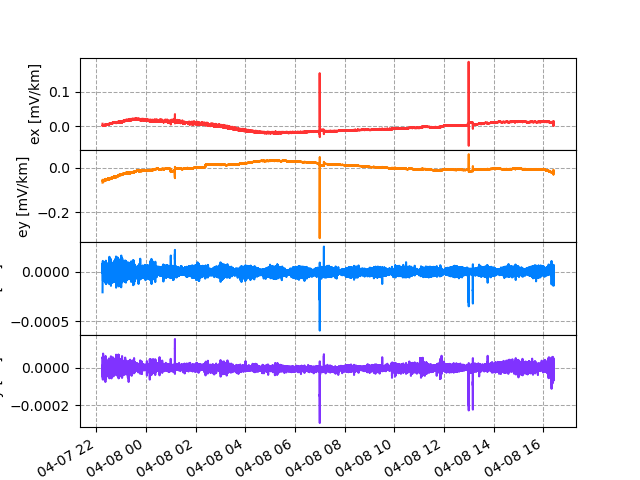

In [12]:
c.plot()

In [15]:
m_qf = MTH5()
m_qf.open_mth5(r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\RR\qf_rr.h5")

In [16]:
r_qf = m_qf.get_run("0948", "0948a", "RR")

In [17]:
r_qf_slice = r_qf.to_runts(start=combined_run.start, end=combined_run.end)

2023-04-18 15:26:28,749 [line 664] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: start time of dataset 2021-04-07T22:14:59+00:00 does not match metadata start 2021-04-04T00:00:00+00:00 updating metatdata value to 2021-04-07T22:14:59+00:00
2023-04-18 15:26:28,753 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-08T16:24:41.980000+00:00 does not match metadata end 2021-04-17T23:59:59.980000+00:00 updating metatdata value to 2021-04-08T16:24:41.980000+00:00


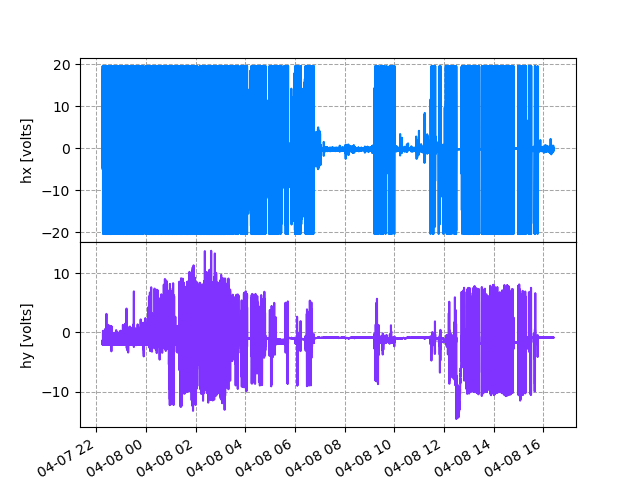

In [18]:
r_qf_slice.plot()

In [19]:
m_qf.close_mth5()

2023-04-18 15:26:41,518 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\RR\qf_rr.h5


## Process With Aurora

In [19]:
# Required imports for the program.
import warnings
from pathlib import Path

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.transfer_function.kernel_dataset import KernelDataset

warnings.filterwarnings("ignore")

In [29]:
station_path = Path(
    r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\{0}\{0}_with_50hz.h5".format(station)
)
obs_path = Path(r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\RR\qf_rr.h5")

In [30]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([station_path, obs_path])
run_summary = mth5_run_summary.clone()
run_summary.add_duration()
run_summary.df = run_summary.df[run_summary.df.sample_rate == 50]
run_summary.mini_summary

2023-04-18 15:00:32,578 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz332\gz332_with_50hz.h5
2023-04-18 15:00:32,656 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\RR\qf_rr.h5


,survey,station_id,run_id,start,end
1,geysers01,gz332,sr50_0001,2021-04-07 22:14:59+00:00,2021-04-08 16:24:41.988000+00:00
8,RR,0854,0854a,2021-04-04 00:00:00+00:00,2021-04-17 23:59:59.980000+00:00
9,RR,0863,0863a,2021-04-04 00:00:00+00:00,2021-04-17 23:59:59.980000+00:00
10,RR,0865,0865a,2021-04-04 00:00:00+00:00,2021-04-17 23:59:59.980000+00:00
11,RR,0874,0874a,2021-04-04 00:00:00+00:00,2021-04-17 23:59:59.980000+00:00
12,RR,0948,0948a,2021-04-04 00:00:00+00:00,2021-04-17 23:59:59.980000+00:00


In [35]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, station, "0948")
mimimum_run_duration = 100  # seconds
kernel_dataset.drop_runs_shorter_than(mimimum_run_duration)
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,geysers01,gz332,sr50_0001,2021-04-07 22:14:59+00:00,2021-04-08 16:24:41.988000+00:00,65382.988
1,RR,0948,0948a,2021-04-07 22:14:59+00:00,2021-04-08 16:24:41.988000+00:00,65382.988


In [36]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(
    kernel_dataset,
    emtf_band_file=r"c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\aurora\aurora\config\emtf_band_setup\bs_six_level.cfg",
)

for decimation in config.decimations:
    decimation.estimator.engine = "RME"
    decimation.window.type = "hamming"
    decimation.output_channels = ["ex", "ey"]

c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\aurora\aurora\config\emtf_band_setup\bs_six_level.cfg


('RR', '0948', '0948a', Timestamp('2021-04-07 22:14:59+0000', tz='UTC'))
  survey station_id run_id                     start  \
0     RR       0948  0948a 2021-04-07 22:14:59+00:00   
1     RR       0948  0948a 2021-04-07 22:14:59+00:00   
2     RR       0948  0948a 2021-04-07 22:14:59+00:00   
3     RR       0948  0948a 2021-04-07 22:14:59+00:00   
4     RR       0948  0948a 2021-04-07 22:14:59+00:00   
5     RR       0948  0948a 2021-04-07 22:14:59+00:00   

                               end input_channels output_channels  \
0 2021-04-08 16:24:41.988000+00:00       [hx, hy]              []   
1 2021-04-08 16:24:41.988000+00:00       [hx, hy]              []   
2 2021-04-08 16:24:41.988000+00:00       [hx, hy]              []   
3 2021-04-08 16:24:41.988000+00:00       [hx, hy]              []   
4 2021-04-08 16:24:41.988000+00:00       [hx, hy]              []   
5 2021-04-08 16:24:41.988000+00:00       [hx, hy]              []   

    channel_scale_factors                         

2023-04-18 15:19:11,765 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-08T16:24:41.960000+00:00 does not match metadata end 2021-04-08T16:24:41.988000+00:00 updating metatdata value to 2021-04-08T16:24:41.960000+00:00
2023-04-18 15:19:12,802 [line 664] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: start time of dataset 2021-04-07T22:14:59+00:00 does not match metadata start 2021-04-04T00:00:00+00:00 updating metatdata value to 2021-04-07T22:14:59+00:00
2023-04-18 15:19:12,806 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-08T16:24:41.960000+00:00 does not match metadata end 2021-04-17T23:59:59.980000+00:00 updating metatdata value to 2021-04-08T16:24:41.960000+00:00


DATASET DF POPULATED
Processing config indicates 6 decimation levels 
After validation there are 6 valid decimation levels
DATASET DF UPDATED


2023-04-18 15:19:15,673 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:15,732 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:17,102 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:17,105 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:17,107 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:17,194 [line 222] mt_me

Processing band 0.514579s
Processing band 0.398591s
Processing band 0.303283s
Processing band 0.234922s


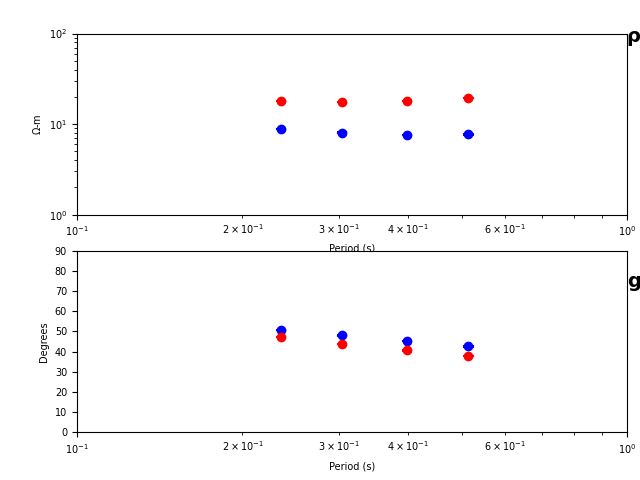

DECIMATION LEVEL 1
DATASET DF UPDATED


2023-04-18 15:19:32,998 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:33,048 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:33,524 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:33,527 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:33,530 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:33,596 [line 222] mt_me

Processing band 2.058317s
Processing band 1.712624s
Processing band 1.377634s
Processing band 1.083917s


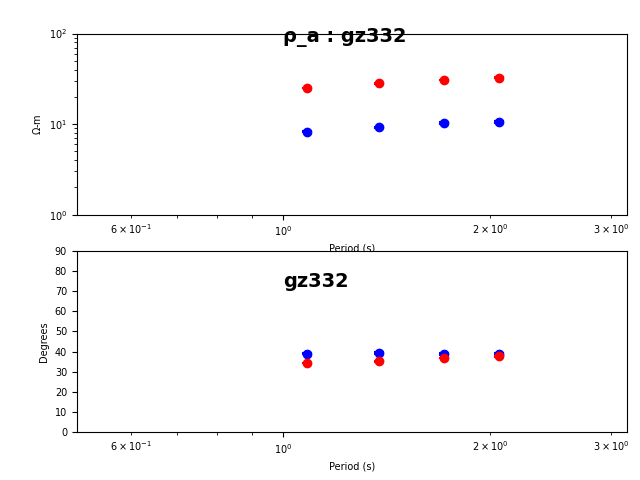

DECIMATION LEVEL 2
DATASET DF UPDATED


2023-04-18 15:19:37,790 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:37,849 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:38,089 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:38,092 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:38,094 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:38,177 [line 222] mt_me

Processing band 8.233270s
Processing band 6.850495s
Processing band 5.510536s
Processing band 4.335666s
Processing band 3.440317s
Processing band 2.664858s


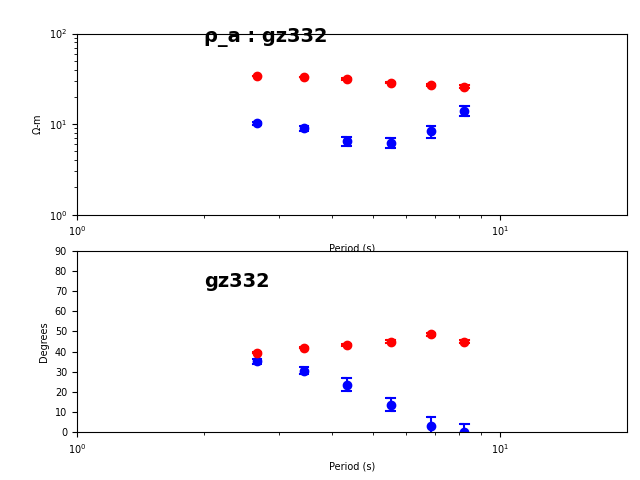

DECIMATION LEVEL 3
DATASET DF UPDATED


2023-04-18 15:19:40,894 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:40,945 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:41,122 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:41,124 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:41,126 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:41,208 [line 222] mt_me

Processing band 30.294027s
Processing band 20.849779s
Processing band 14.467425s
Processing band 10.659431s
Processing band 8.256760s


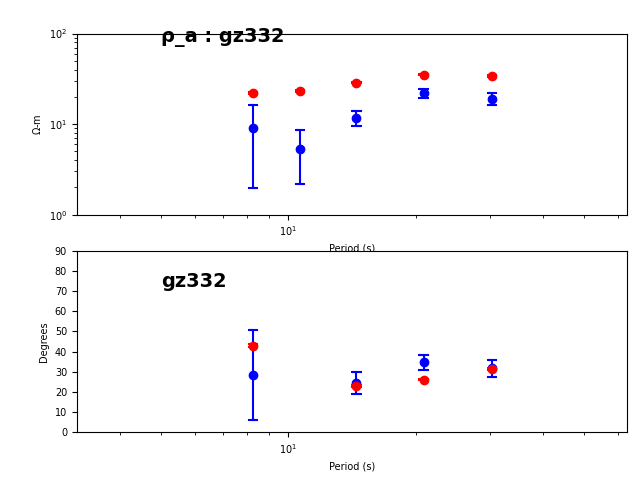

DECIMATION LEVEL 4
DATASET DF UPDATED


2023-04-18 15:19:43,238 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:43,290 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:43,452 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:43,454 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:43,457 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:43,554 [line 222] mt_me

Processing band 121.176107s
Processing band 83.399116s
Processing band 57.869702s
Processing band 42.637725s
Processing band 33.027040s


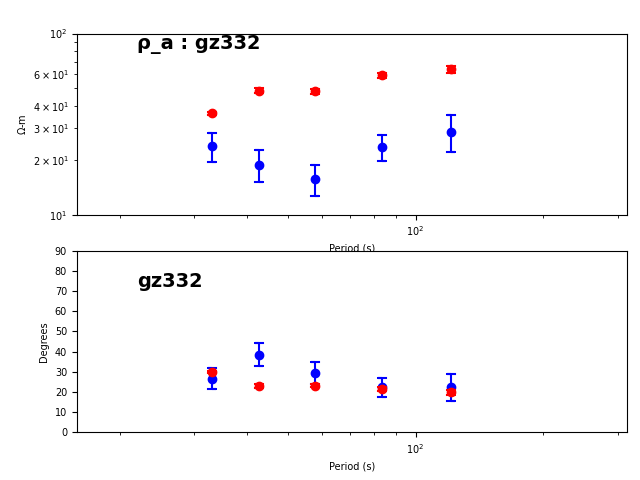

DECIMATION LEVEL 5
DATASET DF UPDATED


2023-04-18 15:19:44,649 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:44,710 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:44,851 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:44,853 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:44,856 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-18 15:19:44,928 [line 222] mt_me

Processing band 484.704427s
Processing band 333.596466s
Processing band 231.478807s
Processing band 170.550899s
Processing band 132.108158s


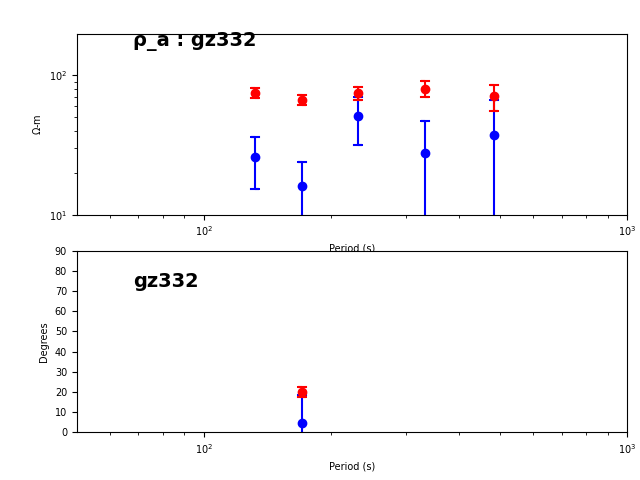

2023-04-18 15:19:48,712 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz332\gz332_with_50hz.h5
2023-04-18 15:19:48,715 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\RR\qf_rr.h5
2023-04-18 15:19:48,737 [line 330] mt_metadata.base.metadata.define_measurement.write_measurement - INFO: No XMEAS information.
2023-04-18 15:19:48,741 [line 215] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz332\gz332_qf0948_rr.edi


=== FINISHED ===
Wall time: 38.9 s


In [37]:
%%time
tf_cls = process_mth5(
    config,
    kernel_dataset,
    units="MT",
    show_plot=True,
    z_file_path=None,
)
print("=== FINISHED ===")
edi = tf_cls.write_tf_file(station_path.parent.joinpath(f"{station}_qf0948_rr.edi"))

## Use MTpy to plot

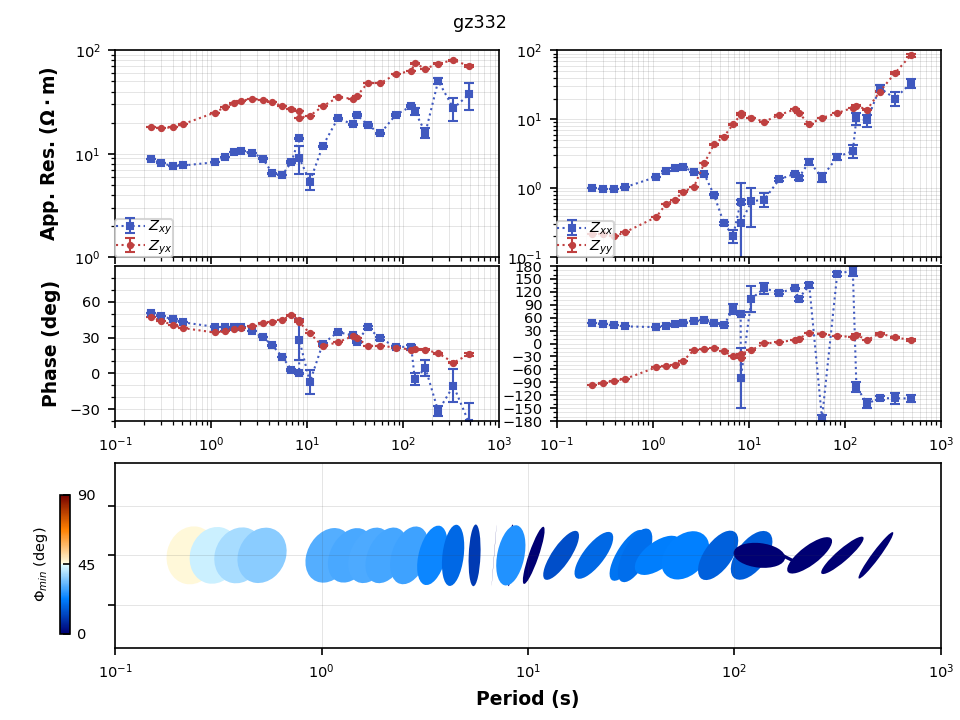

In [38]:
mt_obj = MT()
mt_obj.read_tf_file(edi.fn)
p1 = mt_obj.plot_mt_response(fig_num=5, plot_num=2)